In [434]:
using LinearAlgebra, Plots, FastGaussQuadrature
include("..\\Code_jail\\Misc.jl")
include("..\\Code_jail\\myquad.jl")

Hermite_quad (generic function with 1 method)

# Morituri te salutant

In [435]:
function OrderRoots(x)
    angles = angle.(x)
    sorted_indices = sortperm(angles)
    return x[sorted_indices]
end

OrderRoots (generic function with 1 method)

The Function below in a readable format are, with $w\in\mathbb{C}^m$
$$ϕ = i(k-\frac{1}{x}\sum_{j=1}^mw_jk^{j+1}t^{\frac{m-j}{m+1}})$$
and 
$$P(w,x,t,k) = \exp(i(kx-\sum_{j=1}^mw_jk^{j+1}t^{\frac{m-j}{m+1}})).$$
In the end we would like to compute 
$$∫ \frac{P(w,\text{sgn}(Re(x))xt^{-1/(m+1)},t,k)}{(ik)^n}\mathrm{d}k =∫ \frac{1}{(ik)^n} \exp(it^{-1/(m+1)}(kRe(x)x-t\sum_{j=1}^mw_jk^{j+1}t^{-\frac{j}{m+1}})).$$

In [436]:
ω(w) = (z) -> sum([w[i] .* z.^(i + 1) for i in 1:length(w)])
Dω(w) = (z) -> sum([(i + 1) .* w[i] .* z.^(i) for i in 1:length(w)])
DDω(w) = (z) -> sum([(i + 1) * i .* w[i] .* z.^(i-1) for i in 1:length(w)])

Φ(w, x, t, k) = begin
    ω_kt = ω(w)(k .* t.^(-1 / (length(w) + 1)))
    return 1im*k .- 1im .* ω_kt .* t ./ x 
end

DΦ(w, x, t, k) = begin
    Dω_kt = Dω(w)(k .* t.^(-1 / (length(w) + 1))) .* t.^(-1 / (length(w) + 1))
    return 1im .- 1im .* Dω_kt .* t ./ x 
end

DDΦ(w, x, t, k) = begin
    DDω_kt = DDω(w)(k .* t.^(-1 / (length(w) + 1))) .* t.^(-2 / (length(w) + 1))
    return - 1im .* DDω_kt .* t ./ x 
end

P(w, x, t, k) = begin
    result = exp(x * Φ(w, x, t, k))
    if result ≈ 0.0
        return 0.0
    else
        return result
    end
end

P (generic function with 1 method)

In [437]:
function k0(w, x, t)
    m = length(w);
    a = ones(m) .* 1im
    a[1] = x/(-(m+1)*w[m])
    for i1 = 1:(m-1)
        a[i1+1] = (i1+1)*w[i1]*t^((m-i1)/(m+1))/ ((m+1)*w[m] )
    end
    A = zeros(m,m) * 1im;
    for i1=1:m-1
        A[i1+1,i1] = 1.0;
    end
    A[:,m] = -1. .* a
    E = A |> eigen
    result = E.values |> filter(k -> imag(k) >= -1e-15)
    return OrderRoots(result)
end

k0 (generic function with 1 method)

In [438]:
function ArgD(w, x, t)
    arg = angle.(DDΦ(w, x, t, k0(w, x, t)))
    return [arg]
end

ArgD (generic function with 1 method)

In [439]:
function mod_offset(x, m, offset)
    return offset .+ mod.(x .- offset, m)
end

mod_offset (generic function with 1 method)

In [440]:
function Dirs(w, x, t)
    argd = ArgD(w, x, t)
    return mod_offset(-argd[1] ./ 2 .+ π / 2, π, -π / 2)
end

Dirs (generic function with 1 method)

In [441]:
function ConnectPts(R, w)
    if sign(w[end]) < 0
        return [exp(1im * (4 * m + 1) / (2 * (length(w) + 1)) * π) * R for m in 0:length(w)]
    else
        return [exp(1im * (4 * m - 1) / (2 * (length(w) + 1)) * π) * R for m in 0:length(w)]
    end
end

ConnectPts (generic function with 1 method)

In [442]:
function SomeConnectPts(R, w)
    if sign(w[end]) < 0
        return [exp(1im * (4 * m + 1) / (2 * (length(w) + 1)) * π) * R for m in 0:floor(length(w)/2.)]
    else
        return [exp(1im * (4 * m - 1) / (2 * (length(w) + 1)) * π) * R for m in 0:floor(length(w)/2.) + 1]
    end
end

SomeConnectPts (generic function with 1 method)

In [443]:

function Min2(X, Y)
    out = []
    for x in X
        temp = abs.(Y .- x)
        p1 = argmin(temp)
        temp[p1] = Inf
        p2 = argmin(temp)
        push!(out, (Y[p1], Y[p2]))
    end
    return out
end

Min2 (generic function with 1 method)

In [444]:
function GlobalR(w, x, t)
    return (30 + abs(x)^2 + 1000 / length(w))^(1 / (length(w) + 1))
end

GlobalR (generic function with 1 method)

In [445]:
function Rads(w, xx, tt)
    K0 = k0(w, xx, tt)
    close = Min2(K0, ConnectPts(GlobalR(w, xx, tt), w))
    args = Dirs(w, xx, tt) 
    maxrads = []
    if length(w) > 1
        for i in 1:length(close)
            θ = angle.(close[i][1])
            ϕ = θ - args[i]
            γ = K0[i] * exp(-1im * args[i])
            s = imag(γ) / imag(exp(1im * ϕ))
            r1 = s * exp(1im * ϕ) - γ
            θ = angle.(close[i][2])
            ϕ = θ - args[i]
            γ = K0[i] * exp(-1im * args[i])
            s = imag(γ) / imag(exp(1im * ϕ))
            r2 = s * exp(1im * ϕ) - γ
            push!(maxrads, minimum(abs.([r1, r2])))
        end
    else
        maxrads = [Inf]
    end
    scalerads = [10 / sqrt(abs(DDΦ(w, xx, tt, k)) * abs(xx / 2)) for k in K0]
    
    return K0, args, close, [minimum(r) for r in zip(maxrads, scalerads)]
end

Rads (generic function with 1 method)

In [446]:
function SDPaths(w, xx, tt)
    K0, args, close, rads = Rads(w, xx, tt)
    paths = [K0[i] .+ [rads[i] * exp(1im * (args[i] + π)) 0; 0 rads[i] * exp(1im * args[i])] for i in 1:length(K0)]
    return K0, close, paths
end

SDPaths (generic function with 1 method)

In [447]:
function sortreal(x)
    return sort(x, by=real)
end

sortreal (generic function with 1 method)

In [448]:
function SmallXPath(w, x, t)
    p1 = sortreal(SomeConnectPts(0.5, w))
    p2 = sortreal(SomeConnectPts(GlobalR(w, x, t), w))
    if length(w) == 1
        p1 .+= 0.5 .+ 0im
    end
    s = [];
    c = [];
    for i in 1:length(p1) - 1
        push!(s, [p2[i], p1[i]], [p1[i], p1[i+1]], [p1[i+1], p2[i+1]])
        push!(c, ["inf", "CP_ent"], ["CP_ent", "CP_ext"], ["CP_ext", "inf"])
    end
    return s, c
end

SmallXPath (generic function with 1 method)

In [449]:
function SortAbsIm(x)
    return sort(x, by = x -> abs(imag(x)))
end

SortAbsIm (generic function with 1 method)

In [450]:
function LEOrder(x, y)
    if abs(real(x[1]) - real(y[1])) < eps()
        return imag(x[1]) < imag(y[1])
    else
        return real(x[1]) < real(y[1])
    end
end

LEOrder (generic function with 1 method)

In [451]:
function SortLE(x)
    return sort(x, lt = LEOrder)
end

SortLE (generic function with 1 method)

In [452]:
function flattener(path)
    flatpath = zeros(2*length(path),2) .* 1im; # Correct
    for i1 = 1:2:2*length(path)-1
        flatpath[i1,:] = path[Int(floor((i1-1.)/2.)+1.)][1,:]
        flatpath[i1+1,:] = path[Int(floor((i1-1.)/2.)+1.)][2,:]
    end 
    return flatpath
end

flattener (generic function with 1 method)

In [453]:
function dom_sectioner(path)
    a = -1; b = 1;
    distances = [abs(path[i][2]-path[i][1]) for i in 1:length(path)]; distances .*= (b-a)/sum(distances)
    t_vals = zeros(length(path)+1); t_vals[1] = a; t_vals[end] = b;
    for i1 = 1:length(path)-1
        t_vals[i1+1] = t_vals[i1]+distances[i1]
    end
    return t_vals
end

dom_sectioner (generic function with 1 method)

In [454]:
function pwlinf_maker(t,t_vals,path_nodes,meth)
    t_vals_bd = copy(t_vals);
    if meth == "Hermite" || meth == "Laguerre_L"
        t_vals_bd[1] = -Inf
    end
    if meth == "Hermite" || meth == "Laguerre_R"
        t_vals_bd[end] = Inf
    end
    for i1 = 1:(length(t_vals)-1)
        if (t_vals_bd[i1] <= t && t <= t_vals_bd[i1+1])
            res = (t-t_vals[i1])/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + (t-t_vals[i1+1])/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
            return imag(res) >= -5 ? res : NaN
        end
    end
    return NaN
end

function Dpwlinf_maker(t,t_vals,path_nodes,meth)
    t_vals_bd = copy(t_vals);
    if meth == "Hermite" || meth == "Laguerre_L"
        t_vals_bd[1] = -Inf
    end
    if meth == "Hermite" || meth == "Laguerre_R"
        t_vals_bd[end] = Inf
    end
    for i1 = 1:(length(t_vals)-1)
        if t >= t_vals_bd[i1] && t <= t_vals_bd[i1+1]
            res = 1/(t_vals[i1+1]-t_vals[i1])*path_nodes[i1+1] + 1/(t_vals[i1]-t_vals[i1+1])*path_nodes[i1]
            return imag(res) >= -5 ? res : NaN
        end
    end
    return NaN
end

Dpwlinf_maker (generic function with 2 methods)

In [455]:
function fpath_maker(path,cate)
    t_vals = dom_sectioner(path)
    start_sec = 1
    ind_sec_tmp = [];
    for i1 = 1:length(cate)
        if cate[i1][2] == "inf"
            stop_sec = i1
            push!(ind_sec_tmp,[start_sec, stop_sec+1])
            start_sec = stop_sec+1
        end
    end

    meth = [];
    tt = [];
    funcs = [];
    Dfuncs = [];
    for i1 = 1:length(ind_sec_tmp)
        if ind_sec_tmp[i1][2]-ind_sec_tmp[i1][1] <= 4
            push!(meth, "Legendre")
            xgrid = zeros(ind_sec_tmp[i1][2]-ind_sec_tmp[i1][1]+1) .* 0im;
            for i2 = ind_sec_tmp[i1][1]:(ind_sec_tmp[i1][2]-1)
                xgrid[i2-ind_sec_tmp[i1][1]+1] = path[i2][1];
            end
            xgrid[end] = path[ind_sec_tmp[i1][2]-1][2]

            push!(funcs, t -> pwlinf_maker(t,t_vals[ind_sec_tmp[i1][1]:ind_sec_tmp[i1][2]],xgrid,meth[i1]))
            push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[ind_sec_tmp[i1][1]:ind_sec_tmp[i1][2]],xgrid,meth[i1]))
            #push!(tt, [t_vals[ind_sec_tmp[i1][1]],t_vals[ind_sec_tmp[i1][2]]])
            push!(tt, t_vals[ind_sec_tmp[i1][1]:ind_sec_tmp[i1][2]])
        else
            push!(meth, "Laguerre_L")
            xgrid = zeros(3) .* 0im;
            for i2 = ind_sec_tmp[i1][1]:(ind_sec_tmp[i1][1]+1)
                xgrid[i2-ind_sec_tmp[i1][1]+1] = path[i2][1];
            end
            xgrid[end] = path[ind_sec_tmp[i1][1]+1][2]

            push!(funcs, t -> pwlinf_maker(t,t_vals[ind_sec_tmp[i1][1]:(ind_sec_tmp[i1][1]+2)],xgrid,meth[i1]))
            push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[ind_sec_tmp[i1][1]:(ind_sec_tmp[i1][1]+2)],xgrid,meth[i1]))
            #push!(tt, [t_vals[ind_sec_tmp[i1][1]],t_vals[ind_sec_tmp[i1][1]+1]])
            push!(tt,t_vals[ind_sec_tmp[i1][1]:(ind_sec_tmp[i1][1]+2)])

            for i2 = 1:(ind_sec_tmp[i1][2]-ind_sec_tmp[i1][1]-4)
                push!(meth, "Legendre")
                xgrid = path[ind_sec_tmp[i1][1]+i2+1]

                push!(funcs, t -> pwlinf_maker(t,t_vals[(ind_sec_tmp[i1][1]+i2+1):(ind_sec_tmp[i1][1]+i2+2)],xgrid,meth[i1]))
                push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[(ind_sec_tmp[i1][1]+i2+1):(ind_sec_tmp[i1][1]+i2+2)],xgrid,meth[i1]))
                #push!(tt, [t_vals[(ind_sec_tmp[i1][1]+i2+1)],t_vals[(ind_sec_tmp[i1][1]+i2+2)]])
                push!(tt,t_vals[(ind_sec_tmp[i1][1]+i2+1):(ind_sec_tmp[i1][1]+i2+2)])
            end

            push!(meth, "Laguerre_R")
            xgrid = zeros(3) .* 0im;
            for i2 = (ind_sec_tmp[i1][2]-2):(ind_sec_tmp[i1][2]-1)
                xgrid[i2-ind_sec_tmp[i1][2]+3] = path[i2][1];
            end
            xgrid[end] = path[ind_sec_tmp[i1][2]-1][2]

            push!(funcs, t -> pwlinf_maker(t,t_vals[(ind_sec_tmp[i1][2]-2):ind_sec_tmp[i1][2]],xgrid,meth[i1]))
            push!(Dfuncs, t -> Dpwlinf_maker(t,t_vals[(ind_sec_tmp[i1][2]-2):ind_sec_tmp[i1][2]],xgrid,meth[i1]))
            #push!(tt, [t_vals[(ind_sec_tmp[i1][2]-2)],t_vals[ind_sec_tmp[i1][2]]])
            push!(tt,t_vals[(ind_sec_tmp[i1][2]-2):ind_sec_tmp[i1][2]])

        end
    end
    return funcs, Dfuncs, tt, meth
end

fpath_maker (generic function with 1 method)

In [456]:
struct Deformation
    pp::Vector
    cc::Vector
    path::Vector
    Dpath::Vector
    tt::Vector
    meth::Vector
end

In [457]:
function Deformation(path::Vector,cate::Vector)
    func, Dfunc, tt, meth = fpath_maker(path,cate)
    Deformation(path,cate,func, Dfunc, tt, meth)
end

Deformation

In [458]:
function FullPath(w, xx, tt)
    if abs(xx) < 0.1-eps()
        path, cate = SmallXPath(w, xx, tt)
        return Deformation(path, cate)
    end
    K0, close, paths = SDPaths(w, xx, tt) # Correct
    flatpath = flattener(paths)
    cpts = ConnectPts(GlobalR(w, xx, tt), w) # Correct

    connect = []
    category = []
    for i in 1:length(paths)
        ends = [paths[i][1, 1], paths[i][2, 2]]
        closer = [0., 0.] .* 1im
        if abs(ends[1] - close[i][1]) < abs(ends[2] - close[i][1])
            closer[1] = close[i][1]
        else
            closer[1] = close[i][2]
        end
        if abs(ends[2] - close[i][1]) < abs(ends[1] - close[i][1])
            closer[2] = close[i][1]
        else
            closer[2] = close[i][2]
        end
        
        push!(connect,[closer[1], ends[1]], flatpath[2*i-1,:], flatpath[2*i,:], [ends[2], closer[2]])
        push!(category, ["inf","CP_ent"],["CP_ent","CP"], ["CP","CP_ext"], ["CP_ex", "inf"])
    end
    
    return Deformation(connect,category)
end

FullPath (generic function with 1 method)

In [459]:
function plot_paths(path,cate)
    plot();
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 in 1:length(path)
        plot!([real(path[i1][1]),real(path[i1][2])],[imag(path[i1][1]),imag(path[i1][2])], arrow=true, color =:black, linewidth =2, label ="");
        for i2 in 1:2
            if cate[i1][i2] == "CP"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif cate[i1][i2] == "inf"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif cate[i1][i2] == "CP_ext"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif cate[i1][i2] == "CP_ent"
                scatter!([real(path[i1][i2])],[imag(path[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end
    plot!()|>display
end

plot_paths (generic function with 1 method)

In [460]:
function plot_D(D::Deformation)
    Hermite_label = "Hermite";
    Lagguere_label = "Lagguere";
    Legendre_label = "Legendre";
    plot()
    for i1 = 1:length(D.path)
        t = range(-1,1,1000)
        #t = range(D.tt[i1][1],D.tt[i1][end],100)
        if D.meth[i1] == "Hermite"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:deeppink, linewidth =2, label = Hermite_label)

            x, w = gausshermite(50);
            if length(D.tt[i1]) == 5
                xcenter = D.tt[i1][3];
            else
                xcenter = (D.tt[i1][2]+D.tt[i1][3])/2;
            end
            scatter!(real.(D.path[i1].(x .+ xcenter)),imag.(D.path[i1].(x .+ xcenter)), color =:deeppink, linewidth =2, label = "")

            Hermite_label = "";
        elseif D.meth[i1] == "Lagguere_L" || D.meth[i1] == "Lagguere_R"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:purple2, linewidth =2, label = Lagguere_label)
            Lagguere_label = "";
        elseif D.meth[i1] == "Legendre"
            plot!(real.(D.path[i1].(t)),imag.(D.path[i1].(t)), color =:magenta4, linewidth =2, label = Legendre_label)

            x, w = gausslegendre(10);
            
            trans_func = x -> (D.tt[i1][end] + D.tt[i1][1])/2 + x * (D.tt[i1][end] - D.tt[i1][1])/2 ;

            scatter!(real.(D.path[i1].(trans_func.(x))),imag.(D.path[i1].(trans_func.(x))), color =:magenta4, linewidth =2, label = "")
            Legendre_label = "";
        end
    end
    CP_label = "CP";
    inf_label = "inf";
    CP_ext_label = "CP_ext";
    CP_ent_label = "CP_ent";
    for i1 = 1:length(DD.pp)
        for i2 in 1:2
            if DD.cc[i1][i2] == "CP"
                scatter!([real(DD.pp[i1][i2])],[imag(DD.pp[i1][i2])], color =:green, markersize =5, label = CP_label);
                CP_label = "";
            elseif DD.cc[i1][i2] == "inf"
                scatter!([real(DD.pp[i1][i2])],[imag(DD.pp[i1][i2])], color =:red, markersize =5, label = inf_label)
                inf_label = "";
            elseif DD.cc[i1][i2] == "CP_ext"
                scatter!([real(DD.pp[i1][i2])],[imag(DD.pp[i1][i2])], color =:orange, markersize =5, label = CP_ext_label)
                CP_ext_label = "";
            elseif DD.cc[i1][i2] == "CP_ent"
                scatter!([real(DD.pp[i1][i2])],[imag(DD.pp[i1][i2])], color =:blue, markersize =5, label = CP_ent_label)
                CP_ent_label = "";
            end 
        end
    end
    plot!()|>display
end

plot_D (generic function with 1 method)

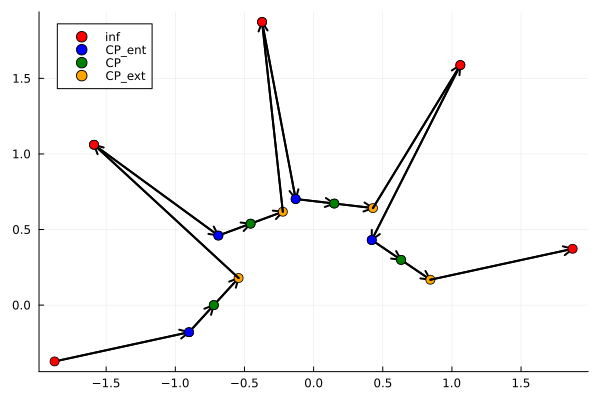

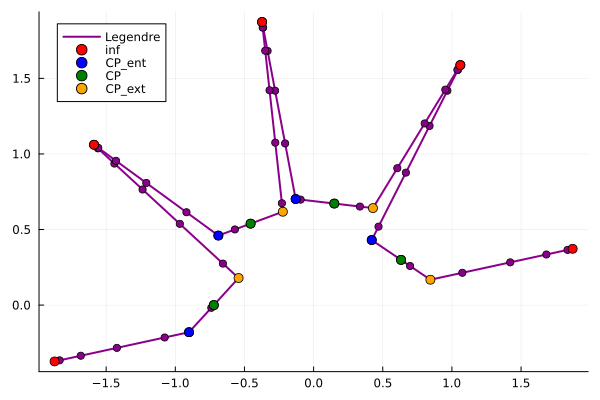

In [461]:
w = -[-2,-9,5,-1,-4,1,3];
xx = 2;
tt = 0.00001;
DD = FullPath(w, xx+eps(), tt);
plot_paths(DD.pp,DD.cc)
plot_D(DD)

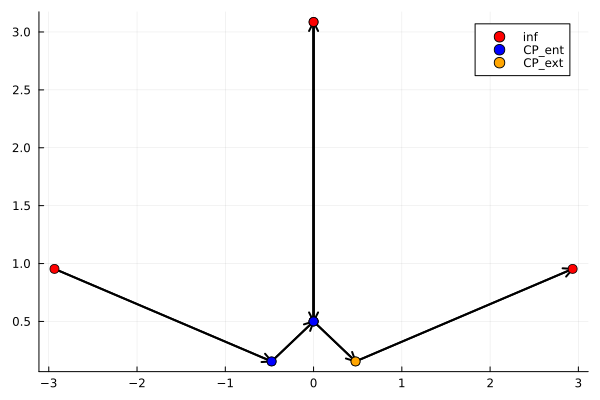

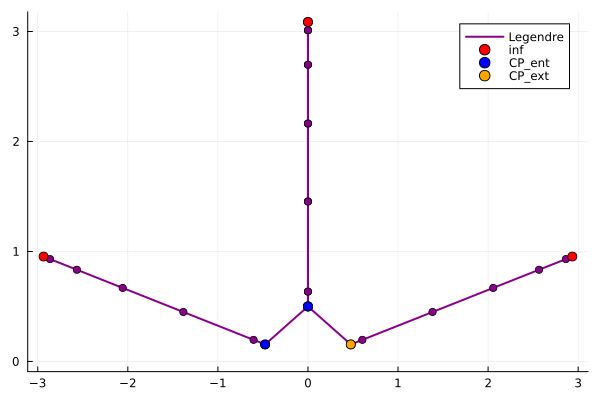

In [463]:
#w = -[-1/2 2 5];
w=  [0,0,0,-1];
xx = 0.0001;
tt = 0.00001;
DD = FullPath(w, xx+eps(), tt);
plot_paths(DD.pp,DD.cc)
plot_D(DD)

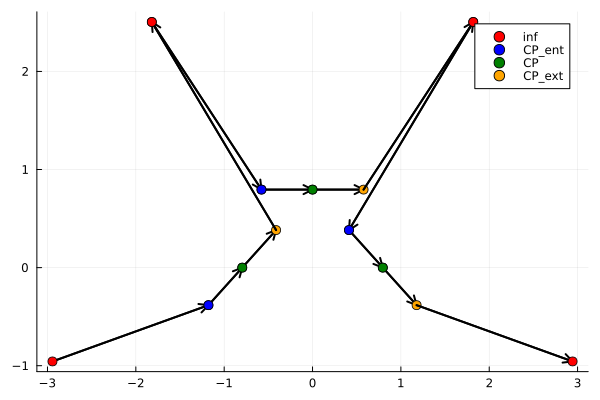

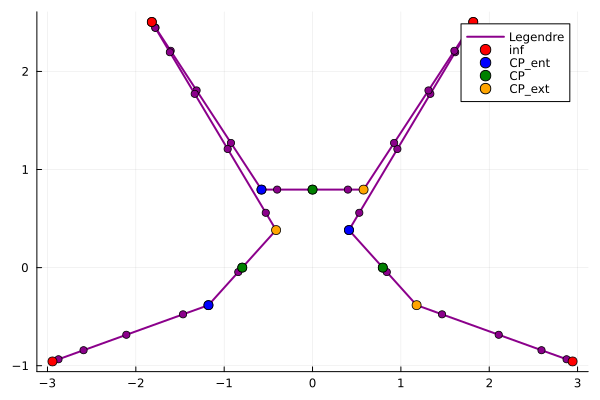

In [465]:
w = [0, 0, 0, 1];
xx = 2;
tt = 10^(-12);
DD =  FullPath(w, xx+eps(), tt);
plot_paths(DD.pp,DD.cc)
plot_D(DD)

In [466]:
function My_Integrate(int_f,Defor,N)
    res = 0im;
    for i1 = 1:length(Defor.tt)
        if Defor.meth[i1] == "Hermite"

            x, w = gausshermite(N);
            if length(Defor.tt[i1]) == 5
                xcenter = Defor.tt[i1][3];
            else
                xcenter = (Defor.tt[i1][2]+Defor.tt[i1][3])/2;
            end
            f = x -> map(int_f,map(Defor.path[i1],x+xcenter)) .* exp(x .^ 2)  .* map(Defor.Dpath[i1],x+xcenter); # map to real line

        elseif Defor.meth[i1] == "Laguerre_L"

            x, w = gausslaguerre(N);
            xcenter = Defor.tt[i1][end]
            f = x -> map(int_f,map(s.c,-(x+xcenter))) .* exp(x)  .* map(s.w,-(x+xcenter)); # map to real line

        elseif Defor.meth[i1] == "Laguerre_R"

            x, w = gausslaguerre(N);
            xcenter = Defor.tt[i1][1]
            f = x -> map(int_f,map(s.c,x+xcenter)) .* exp(x)  .* map(s.w,x+xcenter); # map to real line

        elseif Defor.meth[i1] == "Legendre"

            x, w = gausslegendre(N);
            s = curv(Defor.path[i1],Defor.tt[i1][1],Defor.tt[i1][end],Defor.Dpath[i1],N)
            f = stand_int(int_f,s)
            
        end
        for i2 = 1:length(w)
            res += w[i2] * ( isnan(f(x[i2])) ? 0 : f(x[i2]) )
        end
    end
    return res
end

My_Integrate (generic function with 2 methods)

In [467]:
function Integrand(w, xx, tt, m)
    DD = FullPath(w, xx, tt)
    integrand = z -> (im * z)^m * P(w, xx, tt, z)
    return integrand, DD
end

Integrand (generic function with 1 method)

In [468]:
function SpecialFunction(w, xx, tt, m, N)
    n = length(w) + 1
    if real(xx) >= 0.
        integrand, DD = Integrand(w, sign(real(xx)) * xx * tt^(-1/n), tt, m)
        el = length(SomeConnectPts(1, w)) - 1
    else
        wm = [w[i] * (-1)^(i + 1) for i in 1:length(w)]
        integrand, DD = Integrand(wm, sign(real(xx)) * xx * tt^(-1/n), tt, m)
        el = length(SomeConnectPts(1, wm)) - 1
    end
    if real(xx) < 0.
        extra_c = (-1)^m; 
    else
        extra_c = 1;
    end  
    vals = extra_c * My_Integrate(integrand, DD,N)
    #vals -=  (real(xx) < 0 && m < 0)? 2 * π * im * Residue(z -> (im * z)^m * P(w, xx * tt^(-1/n), tt, z), 0) : 0
    return 1 / (2 * π) * tt^(-(m + 1) / n) * vals
end

SpecialFunction (generic function with 1 method)

In [478]:
w = [0,0,0,-1]
N = 30;
x = 0
t = .001
funt = N -> SpecialFunction(w, x, t, -1, N)
funt(N)

0.0 + 0.0im

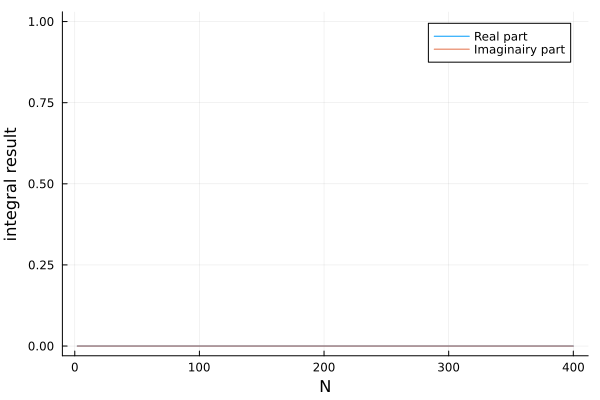

In [471]:
plot(2:400,real.(funt.(collect(2:400))), xlabel = "N", ylabel = "integral result", label = "Real part")
plot!(2:400,imag.(funt.(collect(2:400))), label = "Imaginairy part")

In [481]:
w = -[1]
N = 300;
m = -1;
x = .1
t = .1
funt = N -> SpecialFunction(w, x, t, m, N)
SpecialFunction(w, x, t, m, N)

-0.32667579373958083 + 0.06254612345043456im

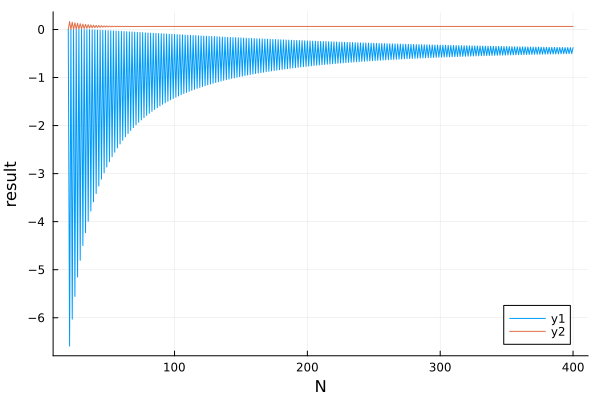

In [482]:
plot(20:400,real.(funt.(collect(20:400))), xlabel = "N", ylabel = "result")
plot!(20:400,imag.(funt.(collect(20:400))))

In [ ]:
n = 50
w = ones(n-1);
N = 300;
funt = (x,t) -> 1 + SpecialFunction(w, x, t, m, N)
funt(1,1)

0.7022630068053214 + 0.05158355030607249im